In [77]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Load Feature-Engineered Data ---
df = pd.read_csv("../data/STT_features.csv", index_col=0, parse_dates=True)
df

C:\Users\olafg\AppData\Local\Temp\ipykernel_40144\4147538612.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("../data/STT_features.csv", index_col=0, parse_dates=True)


,Close,High,Low,Open,Volume,SMA_10,SMA_30,Momentum_10,RSI_14,Rolling_STD_20,Lag_1,Lag_3,Lag_7
Price,,,,,,,,,,,,,
Ticker,STT,STT,STT,STT,STT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-13,57.898040771484375,58.51517811160139,57.69483946397871,58.138874715385306,2536700,56.966312,56.297242,4.079132,65.994928,1.561393,58.244247,58.153923,55.519810
2015-02-17,58.15392303466797,58.26681519941517,56.49066274932354,56.68634211875642,3007900,57.289180,56.270148,3.228676,71.480686,1.625802,57.898041,57.943195,56.212200
2015-02-18,57.386268615722656,58.23671223434131,57.25079916177211,58.06361588547541,2122900,57.411856,56.250079,1.226765,73.073520,1.628442,58.153923,58.244247,57.288429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,73.26791381835938,73.93234333584584,72.9072173016622,73.43876815738999,1536500,72.862604,69.098750,3.056396,60.736674,2.483310,73.097061,73.733009,72.717377
2023-12-26,73.77098083496094,73.95132908822168,73.15400644799278,73.36282921666555,1608600,73.158752,69.418944,2.961487,66.025703,2.315673,73.267914,72.185829,74.558807
2023-12-27,74.0082778930664,74.23608125740549,73.35333507363589,73.69504374101369,1154800,73.429272,69.764449,2.705193,76.099127,2.122698,73.770981,73.097061,73.685547


In [78]:
# --- Define Features and Target (no data leakage!) ---
features = ['SMA_10', 'SMA_30', 'Momentum_10', 'RSI_14', 'Rolling_STD_20', 'Lag_3', 'Lag_7']
target = 'Close'  # we predict the next day's closing price
for col in ["Close", "Open", "High", "Low", "Volume"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
# Shift the target to predict the *next* day's closing price
df['Target'] = df['Close'].shift(-1)
df = df.dropna()
df.dtypes


Close             float64
High              float64
Low               float64
Open              float64
Volume            float64
SMA_10            float64
SMA_30            float64
Momentum_10       float64
RSI_14            float64
Rolling_STD_20    float64
Lag_1             float64
Lag_3             float64
Lag_7             float64
Target            float64
dtype: object

In [79]:
X = df[features]
y = df['Target']

# --- Train/Test Split (avoid data leakage: no shuffle!) ---
split_index = int(len(df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [80]:
# --- Models ---
rf = RandomForestRegressor(random_state=42)
lr = LinearRegression()

rf.fit(X_train_scaled, y_train)
lr.fit(X_train_scaled, y_train)

# --- Predictions ---
y_pred_rf = rf.predict(X_test_scaled)
y_pred_lr = lr.predict(X_test_scaled)

# --- Evaluation Function ---
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {model_name} Results:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2: {r2:.4f}")
    return mae, rmse, r2

# --- Evaluate Models ---
evaluate(y_test, y_pred_rf, "Random Forest")
evaluate(y_test, y_pred_lr, "Linear Regression")



📊 Random Forest Results:
MAE: 1.8656
RMSE: 2.4375
R^2: 0.8727

📊 Linear Regression Results:
MAE: 1.3263
RMSE: 1.7852
R^2: 0.9317


(1.326290598400078, np.float64(1.785229000835474), 0.9317232862697693)

In [81]:
min_len = min(len(y_test), len(y_pred_lr), len(y_pred_rf))
y_test_trimmed = y_test.iloc[:min_len]
y_pred_lr_trimmed = pd.Series(y_pred_lr[:min_len], index=y_test_trimmed.index)
y_pred_rf_trimmed = pd.Series(y_pred_rf[:min_len], index=y_test_trimmed.index)

# Tworzymy wyniki jako DataFrame
results = pd.DataFrame({
    "True": y_test_trimmed,
    "Pred_LR": y_pred_lr_trimmed,
    "Pred_RF": y_pred_rf_trimmed
})

# Dodaj osobno train jako serię
train_plot = pd.Series(y_train, index=y_train.index)

# Upewniamy się, że index to datetime i posortowany
results.index = pd.to_datetime(results.index)
results = results.sort_index()
results = results.astype({"True": float, "Pred_LR": float, "Pred_RF": float})

train_plot.index = pd.to_datetime(train_plot.index)
# Przytnij dane treningowe do momentu przed testowymi
train_plot = train_plot[train_plot.index < results.index.min()]


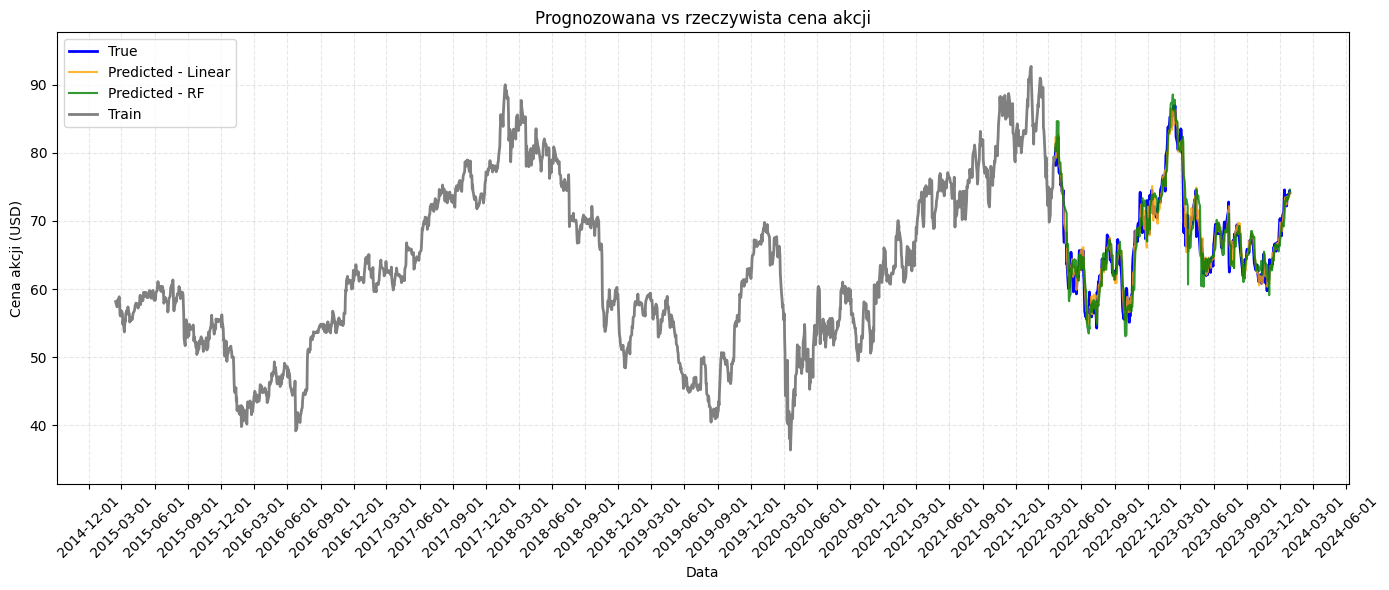

In [82]:

plt.style.use("default")  # reset stylu


plt.figure(figsize=(14, 6))
plt.plot(results.index, results["True"], label="True", linewidth=2, color="blue")
plt.plot(results.index, results["Pred_LR"], label="Predicted - Linear", alpha=0.8, color="orange")
plt.plot(results.index, results["Pred_RF"], label="Predicted - RF", alpha=0.8, color="green")
plt.plot(train_plot.index, train_plot, label="Train", linewidth=2, color="gray")


plt.title("Prognozowana vs rzeczywista cena akcji")
plt.xlabel("Data")
plt.ylabel("Cena akcji (USD)")

# oś X: format dat
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # co 3 miesiące
plt.xticks(rotation=45)

# oś Y: dopasuj zakres
combined = pd.concat([results[["True", "Pred_LR", "Pred_RF"]], train_plot.rename("Train")], axis=1)
combined = combined.select_dtypes(include=[np.number])
ymin = combined.min().min() - 5
ymax = combined.max().max() + 5

plt.ylim(ymin, ymax)

plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


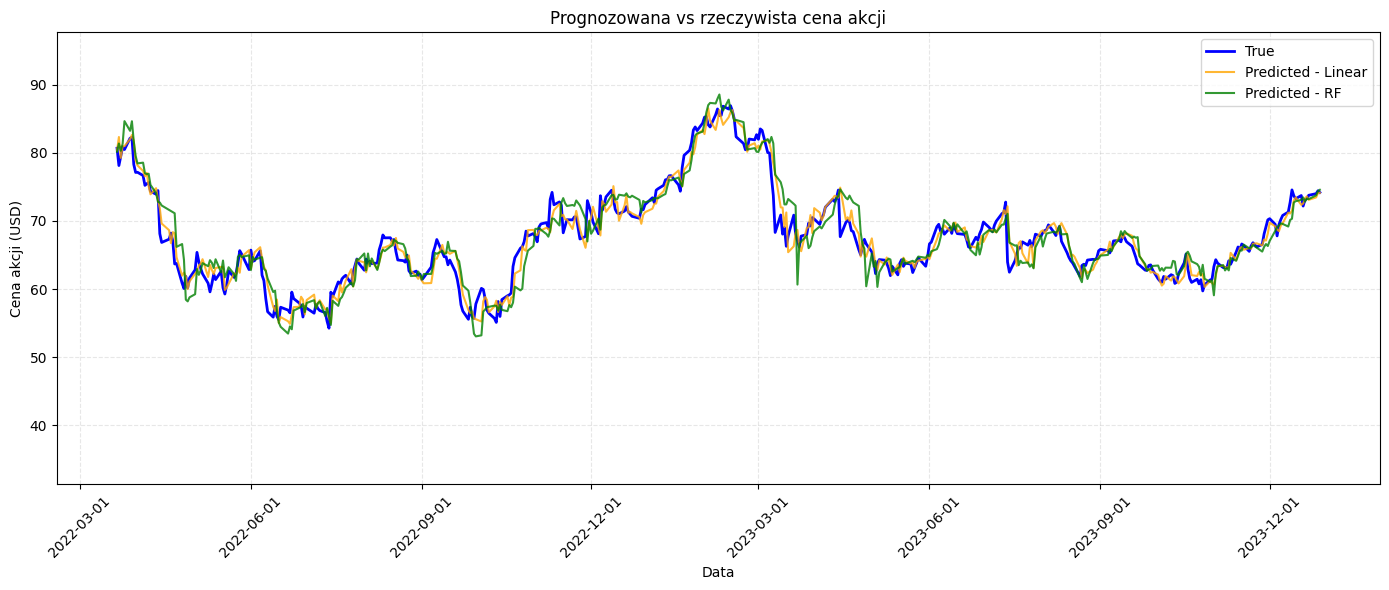

In [83]:
plt.figure(figsize=(14, 6))
plt.plot(results.index, results["True"], label="True", linewidth=2, color="blue")
plt.plot(results.index, results["Pred_LR"], label="Predicted - Linear", alpha=0.8, color="orange")
plt.plot(results.index, results["Pred_RF"], label="Predicted - RF", alpha=0.8, color="green")

plt.title("Prognozowana vs rzeczywista cena akcji")
plt.xlabel("Data")
plt.ylabel("Cena akcji (USD)")

# oś X: format dat
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # co 3 miesiące
plt.xticks(rotation=45)

# oś Y: dopasuj zakres
combined = pd.concat([results[["True", "Pred_LR", "Pred_RF"]], train_plot.rename("Train")], axis=1)
combined = combined.select_dtypes(include=[np.number])
ymin = combined.min().min() - 5
ymax = combined.max().max() + 5

plt.ylim(ymin, ymax)

plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

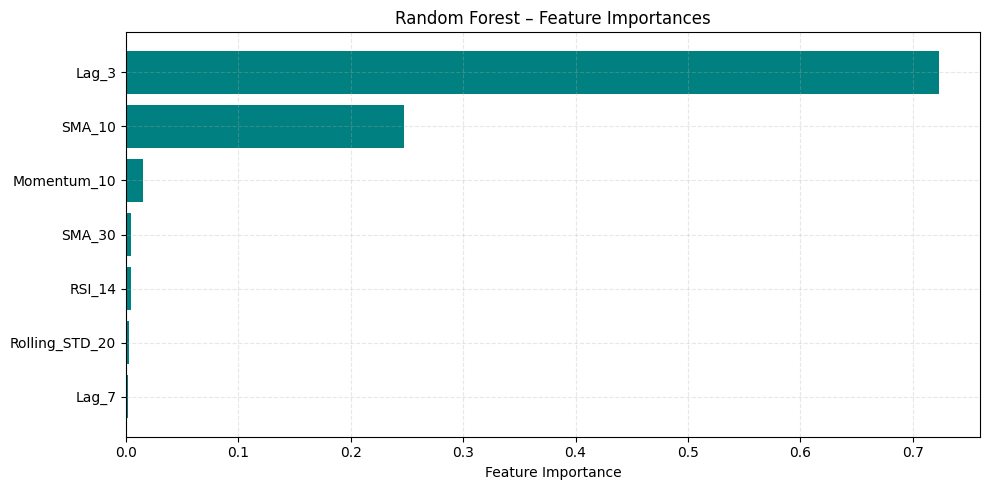

In [84]:
# --- Feature Importance from Random Forest ---
importances = rf.feature_importances_
feature_names = X.columns

# Tworzymy DataFrame dla przejrzystości
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Wykres słupkowy
plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.xlabel('Feature Importance')
plt.title('Random Forest – Feature Importances')
plt.gca().invert_yaxis()  # najważniejsze u góry
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
